In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# 1 Cluster, 2 features

<IPython.core.display.Javascript object>


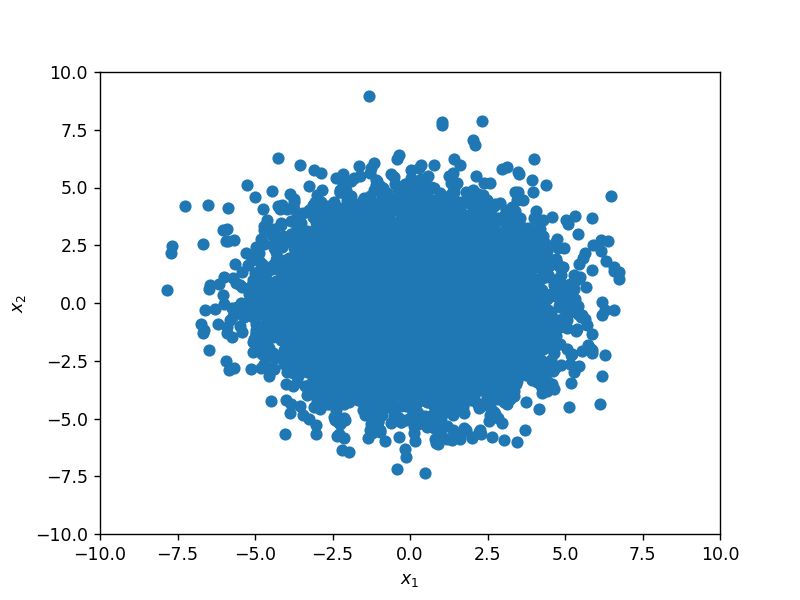

Text(0, 0.5, '$x_2$')

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=10000, centers=[(0,0)], n_features=2, cluster_std=2, random_state=42, shuffle=True)

plt.figure()
plt.scatter(X.T[0], X.T[1])
plt.xlim(-10,10)
plt.ylim(-10,10)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [3]:
def gaussian(x, μ, σ):
    return (1/(np.sqrt(2*np.pi)*σ)) * np.exp(-(x - μ)**2/(2 * σ**2))

In [4]:
def p(x):
    # Mean and variance of the features
    mean = np.array([np.mean(X.T[i]) for i in range(len(X.T))])
    var = np.array([np.mean((X.T[i] - mean[i])**2) for i in range(len(X.T))])
        
    return np.prod([gaussian(x[i], mean[i], var[i]) for i in range(len(X.T))])

In [5]:
def is_anomaly(x_test, ϵ=10e-7):
    if p(x_test) < ϵ:
        return True
    else:
        return False

In [6]:
x_test = np.array([-20,20])
is_anomaly(x_test)

True

# 2 clusters, 2 features

<IPython.core.display.Javascript object>


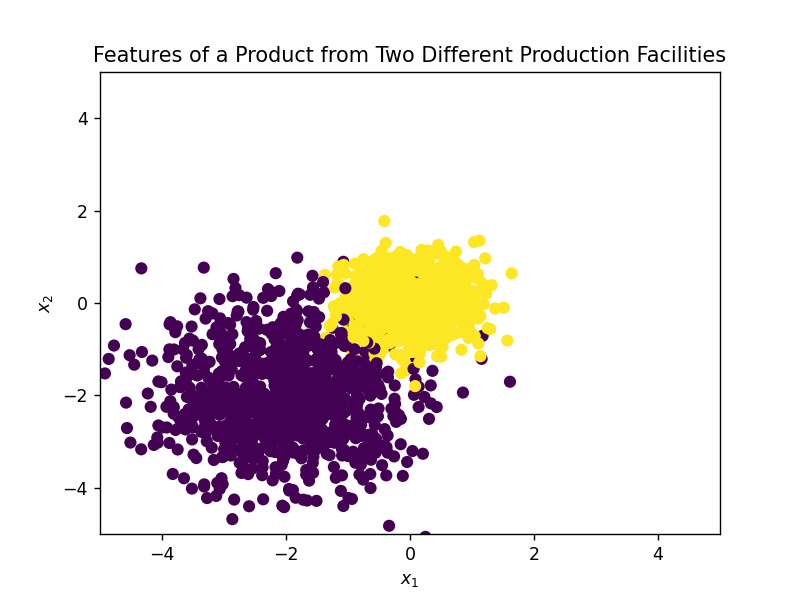

Text(0.5, 1.0, 'Features of a Product from Two Different Production Facilities')

In [10]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=2000, centers=[[-2.0,-2.0], [0,0]], cluster_std=[1, .5],
                  n_features=2, random_state=5, shuffle=True)

plt.figure()
plt.scatter(X.T[0], X.T[1], c=y)
plt.ylim(-5,5)
plt.xlim(-5,5)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Features of a Product from Two Different Production Facilities')

### The two clusters might be a product from two different factories. We assume that the two clusters follow two Gaussians so that we can use a GMM to fit two Gaussians.

### To make an anomaly detection model we simply combine the two Gaussians. Then the qualification for an anomaly is  $p(x_{test}) < ϵ$

In [11]:
from sklearn.mixture import GaussianMixture

k=2
gm = GaussianMixture(n_components=k, random_state=0).fit(X)

In [15]:
print(gm.means_,'\n\n\n', gm.covariances_)

[[-1.75109244e-03  3.32532964e-02]
 [-1.97425150e+00 -1.97027521e+00]] 


 [[[ 0.28207366  0.01552697]
  [ 0.01552697  0.24454534]]

 [[ 1.02501445 -0.00746062]
  [-0.00746062  0.97927823]]]


### Define the multivariate Gaussian distribution

In [16]:
def gaussian_multivariate(x, μ, Σ):
    return np.exp(-(1/2)* (x-μ) @ np.linalg.inv(Σ) @ np.transpose(x-μ)) / (np.sqrt( (2*np.pi)**k * np.linalg.det(Σ)))

### Mixture model

In [17]:
def p_mixture(x, means, variances):
    return np.sum([gaussian_multivariate(x, means[i], variances[i]) for i in range(len(means))])

<IPython.core.display.Javascript object>


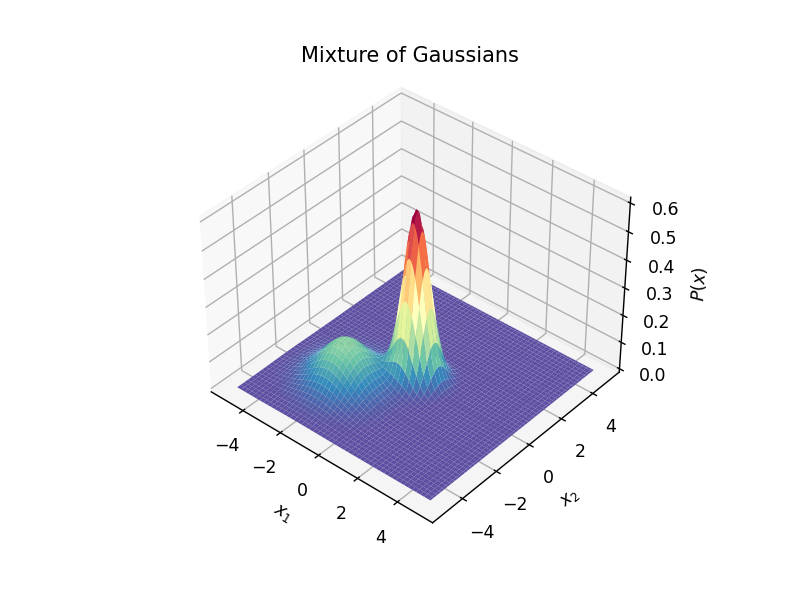

Text(0.5, 0.92, 'Mixture of Gaussians')

In [18]:
square = 5
x1 = np.linspace(-square, square, 100, endpoint=True,)
x2 = np.linspace(-square, square, 100, endpoint=True)

# Meshgrid
x1v, x2v = np.meshgrid(x1, x2)
x1v_rows, x1v_columns = x1v.shape

# Compute for the probability of a particular point in the grid
gaussian_pts = np.zeros(np.array(x1v).shape) 
for i in range(x1v_rows):
    for j in range(x1v_columns):
        gaussian_pts[i,j] =  gaussian_multivariate(np.array([x1v[i,j], x2v[i,j]]), gm.means_[0], gm.covariances_[0]) + gaussian_multivariate(np.array([x1v[i,j], x2v[i,j]]), gm.means_[1], gm.covariances_[1])
        
        
# Plotting code from: https://stackoverflow.com/questions/8510678/trying-to-add-a-3d-subplot-to-a-matplotlib-figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(x1v, x2v, gaussian_pts, cmap='Spectral_r', antialiased=True)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$P(x)$')
ax.set_title('Mixture of Gaussians')

### Criteria

In [19]:
def is_anomaly_mixture(x_test, ϵ=10e-12):
    if p_mixture(x_test, gm.means_, gm.covariances_) < ϵ:
        return True
    else:
        return False

# Test our model

In [20]:
x_test = np.array([3.75, 0.62])
is_anomaly_mixture(x_test, ϵ=10e-6)

True

# Plot

<IPython.core.display.Javascript object>


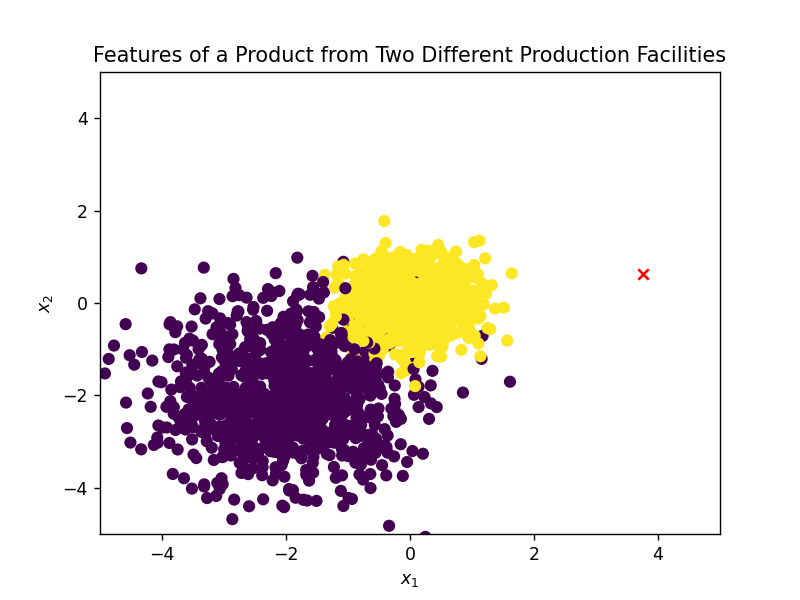

Text(0.5, 1.0, 'Features of a Product from Two Different Production Facilities')

In [21]:
plt.figure()
plt.scatter(X.T[0], X.T[1], c=y)

# If x_test is an anomaly
if is_anomaly_mixture(x_test, ϵ=10e-6):
    plt.scatter(x_test[0], x_test[1], marker='x', c='r')
    
# If x_test is notan anomaly 
else:
    plt.scatter(x_test[0], x_test[1], marker='x', c='b')
    
plt.ylim(-5,5)
plt.xlim(-5,5)

plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Features of a Product from Two Different Production Facilities')